
>> Build first h(t)


100%|██████████| 54/54 [00:06<00:00,  9.75it/s]


>> Find the first 0 to get kinectic H2O(in) -> H2O(out)



100%|██████████| 54/54 [00:00<00:00, 242.10it/s]


>> Build correlation h(t)



100%|██████████| 54/54 [00:00<00:00, 6439.38it/s]


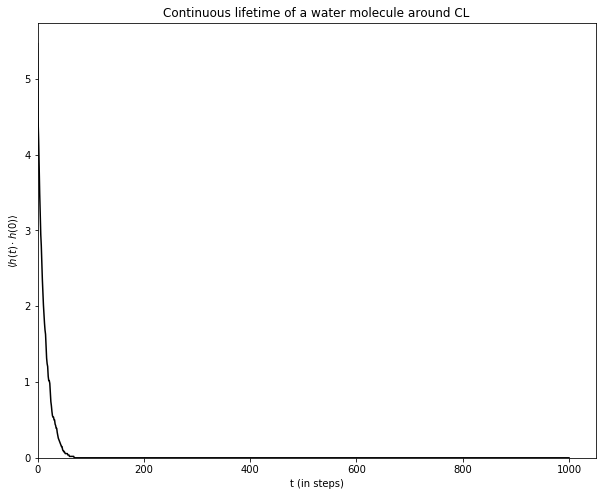

In [4]:
import numpy as np
import mdtraj as md
import tqdm as tq
import matplotlib.pyplot as plt

##########################
#Parameters
##########################
datafile = "spcebox.dcd"            #absolute path of data
topofile = "spcebox-post.psf"       #absolute path to box

#Stride
dt       = DCDTIMESTEP                       #Time step of between two time configurations
NT       = 1                        #Time steps keep for analysis (1 = 'all', 2 = '1 every 2')

#Atom type
R       = RADIUSVALUE                       #Cut-off in nm
atom    = 'ANION'                       #Atom Type

#Plot labels
xlabel  = 't (in steps)'
ylabel  = 'Number of water molecules still in the shell'

#Residue number :
# *** TO BE UPDATED FOR EACH SYSTEM ***
labeltonumber = {'H2O' : 0, 'K' : 1, 'ANION' : 2}  #
atomnumber    = {'H2O' : (0, 2997, 3), 'K' : (2997, 2997 + 54, 1), 'ANION' : (2997 + 54, 2997 + 2 * 54, 1)}

#Export data
save          = 'hcorr'                #None if not save, else string

#types
dtype_i = np.int32
dtype_f = np.float32

##########################
#Code
##########################
def RPBC(xyz, L) :
    """Estimate the radius around a given reference atom."""

    #Correct lengths
    filt_lo = xyz < -L[None, None, :] / 2        #Adapt L shape
    filt_hi = xyz > L[None, None, :] / 2

    #Correct lengths
    for nax in range(xyz.shape[2]) :
        xyz[filt_hi[..., nax], nax] -= L[nax]
        xyz[filt_lo[..., nax], nax] += L[nax]

        #print(xyz[..., nax].min(), xyz[..., nax].max(), flush = True)

    return np.sqrt(np.sum(xyz**2, axis = -1))

def indices(n0, nf, nt) :
    """Select the atom indices you want."""
    return np.arange(n0, nf, nt, dtype = dtype_i)

#Load trajectory
traj = md.load(datafile, top = topofile, stride=NT)

#Get parameters
trajsplit = [traj.atom_slice(indices(*atomnumber[atom])) for atom in atomnumber.keys()]

Nframes = traj.n_frames                                             #Number of frame
Nmol    = [trajsplit[n].n_atoms for n in range(len(trajsplit))]     #Number of mol for 0 and 1
XYZ     = [trajsplit[n].xyz for n in range(len(trajsplit))]         #Trajectory
L       = traj.unitcell_lengths[0]                                  #Box lengths at t=0


#Allocate a boolean with 0 an 1, representation h.
h = np.zeros((Nmol[labeltonumber[atom]], Nframes, Nmol[labeltonumber['H2O']]), dtype = dtype_i)

print("\n>> Build first h(t)", flush = True)
for n in tq.tqdm(range(Nmol[labeltonumber[atom]])) :
    xyz_ref = XYZ[labeltonumber[atom]][:, n:n+1, :]
    xyz_H2O = XYZ[labeltonumber['H2O']]

    #Build radius + correction PBC
    r = RPBC(xyz_H2O - xyz_ref, L)

    #Convert it to boolean
    h[n, ...] = r < R                               #Sequence of 0 : r > R, 1 : r < R


print("\n>> Find the first 0 to get kinectic H2O(in) -> H2O(out)", flush = True)
#Find the first occurence of 0 if h not in sphere
i0 = np.argmin(h, axis = 1)                         #Find the occurence of 0 in time axis
for nsol in tq.tqdm(range(Nmol[labeltonumber[atom]])) :
    for nW in range(Nmol[labeltonumber['H2O']]) :
        h[nsol,i0[nsol, nW]:,nW] = 0                #All the indices i > i0 go to 0


#Mean over all the reference atom the product \sum_i <h_i(t).h_i(0)>
print("\n>> Build correlation h(t)", flush = True)

hcorr = np.zeros((Nframes,), dtype = dtype_f)
for n in tq.tqdm(range(Nmol[labeltonumber[atom]])) :
    #Find water molecules with h(0) = 1
    select_H2O_n = h[n, 0, :] == 1

    #Sum over it
    hcorr += np.sum(h[n, :, select_H2O_n] * h[n, 0:1, select_H2O_n], dtype = dtype_f, axis = 0)

#Average by the number of mols
hcorr /=  Nmol[labeltonumber[atom]]

#Time axis
t = dt * np.arange(Nframes, dtype = dtype_f)

fig = plt.figure(figsize = (10,8))
ax = fig.subplots()
ax.plot(t, hcorr, color = 'black')
ax.set_title("Continuous lifetime of a water molecule around " + atom)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_xlim(0,None)
ax.set_ylim(0,None)

#Export fig and data in txt format
if bool(save) :
    fig.savefig(save + '_' + atom + '.png', transparent = False, format = 'png')
    np.savetxt(save + '_' + atom + '.txt', np.concatenate([t[:,None],hcorr[:,None]], axis = -1), header = 't h2')
